# Project proposal: Stock-price prediction

Stock market prediction has attracted much attention from academia as well as business. Due
to the non-linear, volatile and complex nature of the market, it is quite difficult to predict. As
the stock markets grow bigger, more investors pay attention to develop a systematic approach
to predict the stock market. Since the stock market is very sensitive to the external information,
the performance of previous prediction systems is limited by merely considering the traditional
stock data. New forms of collective intelligence have emerged with the rise of the Internet (e.g.
Google Trends, Wikipedia, etc.). The changes on these platforms will significantly affect the
stock market. In addition, both the financial news sentiment and volumes are believed to have
impact on the stock price.

In this project, you should develop and evaluate a prediction model that could be used to predict
the stocks’ short-term movement, and price. Besides historical data directly from the stock
market, some external data sources should also be considered as inputs to the model.

In summary, the contributions to this work are listed below:

1. Detect the potential factors(features) that could impact the stock market and acquire the
data from disparate data sources: 
    
    (a) publicly available market information on stocks such as Yahoo Finance, including opening/closing prices, trade volume, etc.; 

    (b) commonly used technical indicatorsfrom Yahoo finance that reflect price variation over time such as Stochastic Oscillator (%K), the Larry William (LW) % R Indicator and the Relative Strength Index (RSI) ; 

    (c) daily counts of Google Trends on the stocks of interest; 
     
    (d) the number of unique visitors for pertinent Wikipedia pages per day.

2. Use a variable selection method such as PCA, Correlation Coefficient or any other suitable methods to filter the most important features.

3. Make use of Artificial Neural Networks and most important featuresfrom disparate data sources to build the forecasting model.

4. The proposed model should allow investors to predict the next-day Closing, Opening or both prices for a particular stock or index.

5. Evaluate the prediction model based on different metrics(ex. MSE, MAPE) and provide decision making suggestions for the investors.

Note 1: You can use any stock such as AAPL for Apple, GOOG for Google, and etc.

Note 2. Use the best practices you learned in the course to solve the problem.
To obtain more information about this project, you can refer to the Chapter 2 of the
following paper: Application of machine learning techniques for stock market
prediction, Bin Weng, 2017.


# Factors 
Hvilke variabler må være med i modellen?

1. price on market open and close, trade volume, etc
2. technical indicators: Stochastic, Willams %R, Relative Strength Index ...
simple moving average?
3. daily count of Google Trends on the stock of interest
4. the number of unique visitors for pertinent Wikipedia pages per day 




In [20]:
# import guide https://colab.research.google.com/notebooks/snippets/importing_libraries.ipynb

!pip install yfinance
!pip install pytrends --upgrade
!pip install --upgrade --user git+https://github.com/GeneralMills/pytrends

Requirement already up-to-date: pytrends in c:\users\marti\stock-prediction\venv\lib\site-packages (4.7.3)


You should consider upgrading via the 'c:\users\marti\stock-prediction\venv\scripts\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'c:\users\marti\stock-prediction\venv\scripts\python.exe -m pip install --upgrade pip' command.
ERROR: Can not perform a '--user' install. User site-packages are not visible in this virtualenv.
You should consider upgrading via the 'c:\users\marti\stock-prediction\venv\scripts\python.exe -m pip install --upgrade pip' command.


# Libraries
Yahoo finance - yfinance: get stock data..


In [48]:
import yfinance as yf # eller bare pandas datareader?
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import datetime
import sklearn
from datetime import date, datetime as dt, timedelta
from pytrends.request import TrendReq
#pytrends = TrendReq(timeout=(10,25), proxies=['https://34.203.233.13:80',], retries=2, backoff_factor=0.1, requests_args={'verify':False})
pytrends = TrendReq()

Enter desired ticker

In [22]:
# Yahoo finance - get data
TICKER = 'AAPL'

stock = yf.Ticker(TICKER)
stock.info

{'zip': '95014',
 'sector': 'Technology',
 'fullTimeEmployees': 147000,
 'longBusinessSummary': 'Apple Inc. designs, manufactures, and markets smartphones, personal computers, tablets, wearables, and accessories worldwide. It also sells various related services. The company offers iPhone, a line of smartphones; Mac, a line of personal computers; iPad, a line of multi-purpose tablets; and wearables, home, and accessories comprising AirPods, Apple TV, Apple Watch, Beats products, HomePod, iPod touch, and other Apple-branded and third-party accessories. It also provides AppleCare support services; cloud services store services; and operates various platforms, including the App Store, that allow customers to discover and download applications and digital content, such as books, music, video, games, and podcasts. In addition, the company offers various services, such as Apple Arcade, a game subscription service; Apple Music, which offers users a curated listening experience with on-demand r

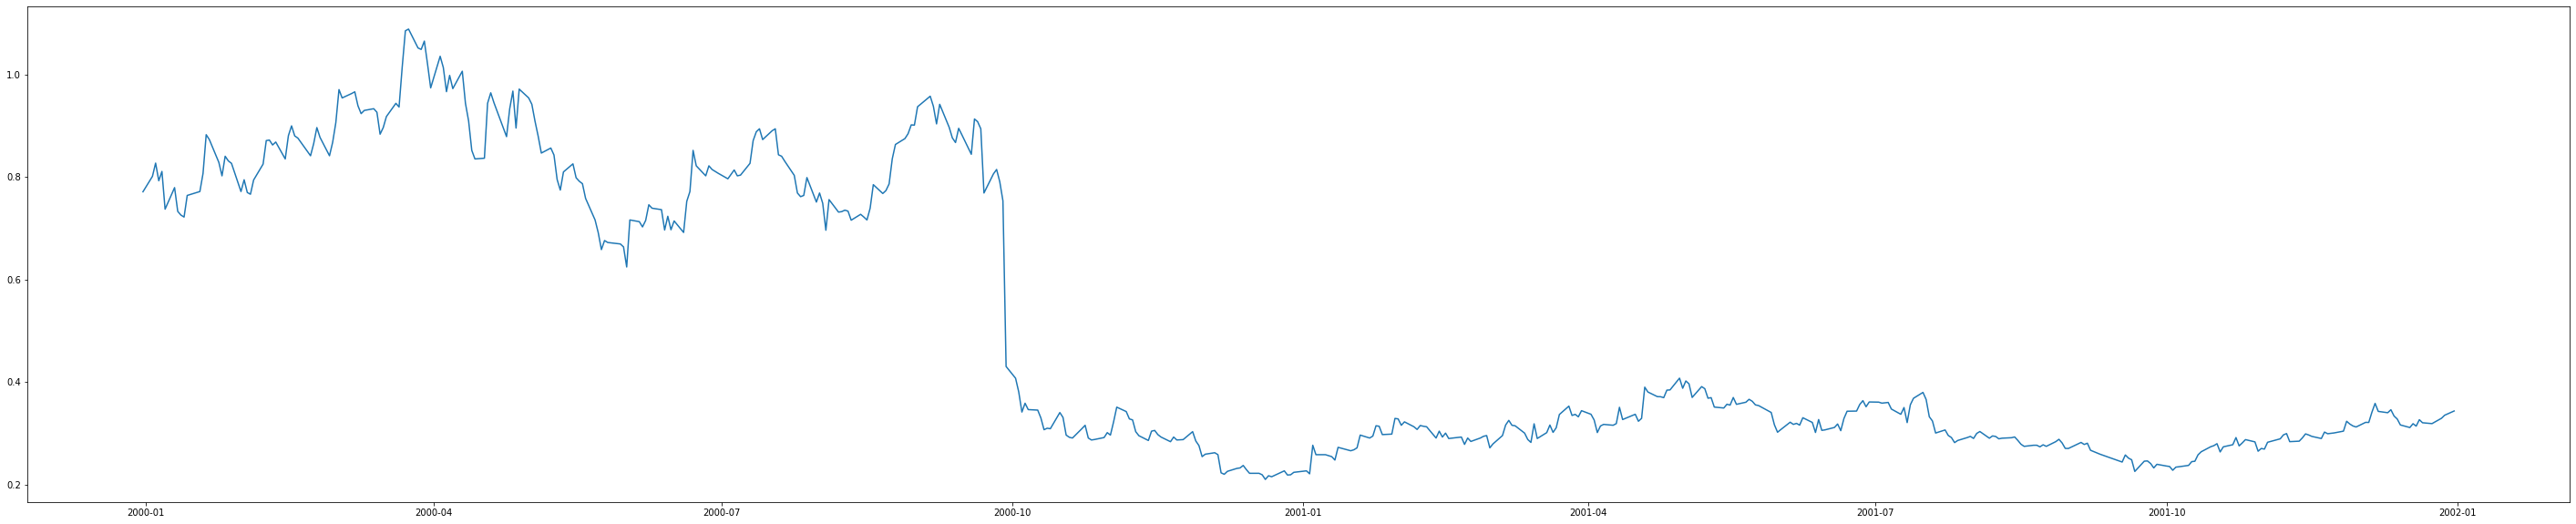

In [23]:
stock.history(interval='1d', start='2000-1-1', end = '2002-1-1')
stock_open_price = stock.history(interval='1d', start='2000-1-1', end = '2002-1-1')['Open']

# setup figure
plt.ylim = stock.history(interval='1d', start='2000-1-1', end = '2002-1-1')[['Open','Close']].values.max() * 1.1
plt.figure(figsize=(50,10))

plt.plot(stock_open_price.index, stock_open_price.values)

In [47]:
# help(sklearn)

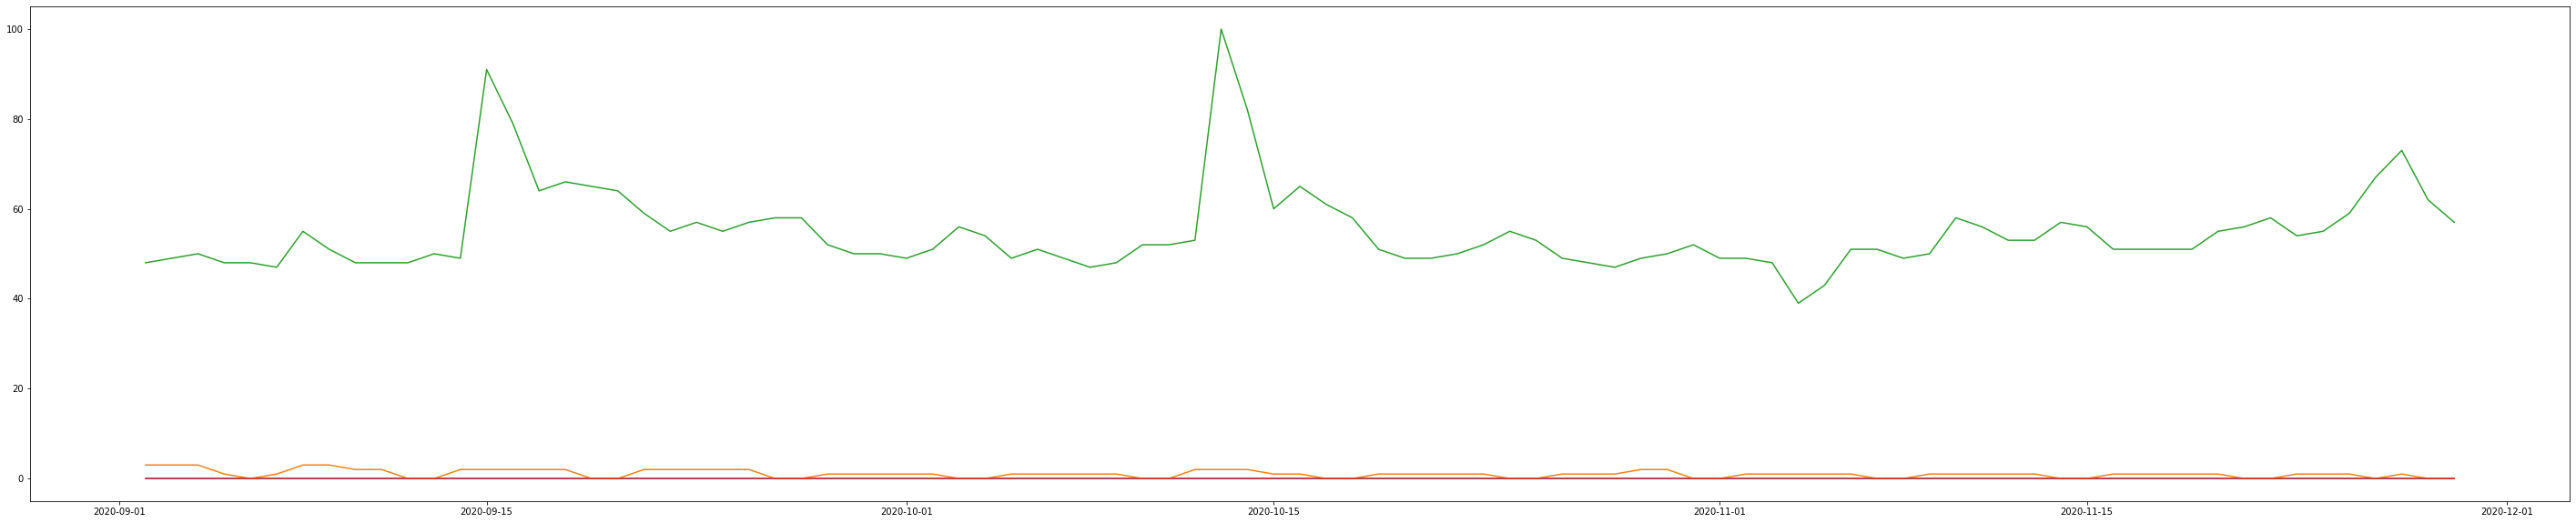

In [45]:
def get_company_name(comp_name):
    if len(comp_name) > 2:
        return comp_name[0:1]
    else:
        return comp_name[0]

def split_date(from_date):
    # if date is longer than 3 months, split into 3 month array
    if from_date > dt.now()-pd.DateOffset(months=3):
        return



def get_google_data(kw_list, from_date):
    # keyword_list = [stock.info['shortName'], stock.info['symbol'], get_company_name(stock.info['shortName'].split(' '))]
    if type(from_date) == type(date):
        periods = split_date(from_date)
    else: return None

    trend = []
    for period in periods:
        pytrends.build_payload(kw_list, cat=0, timeframe='3-m 5-m', geo='', gprop='')
        trend.append(pytrends.interest_over_time())
    return trend

ipo_date = stock.history(period='max').index.min()

# Google trends data
keyword_list = [stock.info['shortName'], stock.info['symbol'], get_company_name(stock.info['shortName'].split(' '))]

#pytrend.build_payload(kw_list=[keyword_list])



plt.figure(figsize=(50,10))
plt.plot(trend)

In [66]:
kw_list = [stock.info['shortName'], stock.info['symbol'], get_company_name(stock.info['shortName'].split(' '))]

pytrends.build_payload(kw_list, cat=0, timeframe='today 3-m', geo='', gprop='')
trend = pytrends.interest_over_time()
trend

ResponseError: The request failed: Google returned a response with code 400.

In [72]:
from pytrends import dailydata

kw_list = [stock.info['shortName'], stock.info['symbol'], get_company_name(stock.info['shortName'].split(' '))]

# pytrends.build_payload(kw_list, cat=0, timeframe='today 3-m', geo='', gprop='')
trend = dailydata.get_daily_data(kw_list[0], 2016, 1, 2020,12)
trend.to_csv(path_or_buf='/googledata/'+kw_list[0]+'.csv')

Apple Inc.:2016-01-01 2016-01-31
Apple Inc.:2016-02-01 2016-02-29
Apple Inc.:2016-03-01 2016-03-31
Apple Inc.:2016-04-01 2016-04-30
Apple Inc.:2016-05-01 2016-05-31
Apple Inc.:2016-06-01 2016-06-30
Apple Inc.:2016-07-01 2016-07-31
Apple Inc.:2016-08-01 2016-08-31
Apple Inc.:2016-09-01 2016-09-30
Apple Inc.:2016-10-01 2016-10-31
Apple Inc.:2016-11-01 2016-11-30
Apple Inc.:2016-12-01 2016-12-31
Apple Inc.:2017-01-01 2017-01-31
Apple Inc.:2017-02-01 2017-02-28
Apple Inc.:2017-03-01 2017-03-31
Apple Inc.:2017-04-01 2017-04-30
Apple Inc.:2017-05-01 2017-05-31
Apple Inc.:2017-06-01 2017-06-30
Apple Inc.:2017-07-01 2017-07-31
Apple Inc.:2017-08-01 2017-08-31
Apple Inc.:2017-09-01 2017-09-30
Apple Inc.:2017-10-01 2017-10-31
Apple Inc.:2017-11-01 2017-11-30
Apple Inc.:2017-12-01 2017-12-31
Apple Inc.:2018-01-01 2018-01-31
Apple Inc.:2018-02-01 2018-02-28
Apple Inc.:2018-03-01 2018-03-31
Apple Inc.:2018-04-01 2018-04-30
Apple Inc.:2018-05-01 2018-05-31
Apple Inc.:2018-06-01 2018-06-30
Apple Inc.